In [ ]:
!pip3 install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.1 MB/s eta 0:00:00


In [ ]:
!pip install numba
!pip install tf-models-official
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 26.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=b202ce3fba6fb68395caece2c996a9d72c9292d3135ab9ffd9c25db0839377e5
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt


In [ ]:
import numpy as np
import pandas as pd
import nltk
import string

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving preprocessed_data.csv to preprocessed_data.csv


In [ ]:
import pandas as pd

reviews = pd.read_csv("preprocessed_data.csv")

In [ ]:
reviews.shape

(1000, 2)

In [ ]:
reviews.head

<bound method NDFrame.head of                                                 Review  Sentiment
0                            way plug unless converter          0
1                            good case excellent value          1
2                                        great jawbone          1
3    tie charger conversation last minutesmajor pro...          0
4                                            mic great          1
..                                                 ...        ...
995            screen get smudge easily touch ear face          0
996                         piece junk lose call phone          0
997                                 item match picture          0
998               thing disappoint infra red port irda          0
999                        answer call unit never work          0

[1000 rows x 2 columns]>

In [ ]:
from sklearn.model_selection import train_test_split

#split and take the test set
X, X_test, y, y_test = (train_test_split(reviews['Review'], reviews['Sentiment'],
                                                     stratify=reviews['Sentiment'],
                                                     test_size=0.2,
                                                     train_size=0.8
                                                     ))


In [ ]:

#split the train set (X) into train and validation
X_train, X_val, y_train, y_val = (train_test_split(X, y,
                                                     stratify=y,
                                                     test_size=0.25,
                                                     train_size=0.75
                                                     ))

In [ ]:
X_train

489            result phone either stuck max volume mute
355         loudspeaker option great bumper light appeal
526                                 horrible switch time
221    kind embarrass use look mostly embarrass child...
217     also didnt like button felt like would crack use
                             ...                        
887                                    best headset ever
222                         simple lightweight great fit
16                                  advise everyone fool
657    handsfree part work fine car try download addr...
558              virgin wireless rock cheap little phone
Name: Review, Length: 600, dtype: object

In [ ]:
X_val

278                          best rotate feature helpful
478    hold charge long time reasonably comfortable l...
455                               good wear hat sunglass
15                 highly recommend one blue tooth phone
759                                     best headset use
                             ...                        
196                                      youll love thin
891           fit comfortably come three size earbud tip
971                                    excellent product
292                                      excellent phone
45                                          feature want
Name: Review, Length: 200, dtype: object

In [ ]:
X_test

296    work great cat attack phone scratch protective...
162           essentially communication tool communicate
19     click place way make wonder long mechanism wou...
939             like fact rest lightly ear rather inside
404                                dont waste money time
                             ...                        
52     usable keyboard actually turn pda realworld us...
434                 get well reception clarity phone ive
668                            much less jawbone replace
38                                  case great work fine
304    everything work first trythe device certainly ...
Name: Review, Length: 200, dtype: object

In [ ]:
#@title Choose a BERT model to fine-tune

#the model has 5 layers (L), 512 hidden size H and 8 attention heads
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
reviews['Review'][0]

'way plug unless converter'

In [ ]:
text_test = ["way plug unless converter"]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2126 13354  4983 10463  2121   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.99782234  0.946317    0.15413384  0.20598885  0.36283374  0.9945108
  0.9745832  -0.9982807  -0.5551914  -0.9991993   0.00500135 -0.9001267 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.1242591  -0.10283401 -0.41193774 ... -1.1065642   0.08412562
   0.35013586]
 [-0.82978183  1.2974806   0.20641452 ... -0.05894662  0.5495693
   0.32727122]
 [-0.93751884  0.6387986  -0.4910738  ... -0.39848477  0.23541373
   0.05987689]
 ...
 [ 0.0800344   0.88095343 -0.00896905 ... -0.26908678  0.29238924
   0.4636891 ]
 [ 0.3235723   0.67658097  0.47537348 ... -0.38818753  0.17438473
  -0.4887391 ]
 [ 0.43736294  0.77230406 -0.13917735 ... -0.2579316   0.68554544
   0.16769473]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

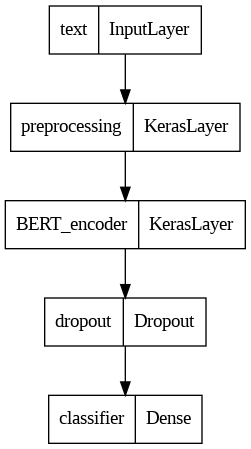

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
epochs = 6
steps_per_epoch = 600  #corresponding to the train set size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps) #10% of num_train_steps

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [ ]:
#fine-tune BERT for classification
classifier_model.compile(optimizer,
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=[tf.keras.metrics.BinaryAccuracy()])
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

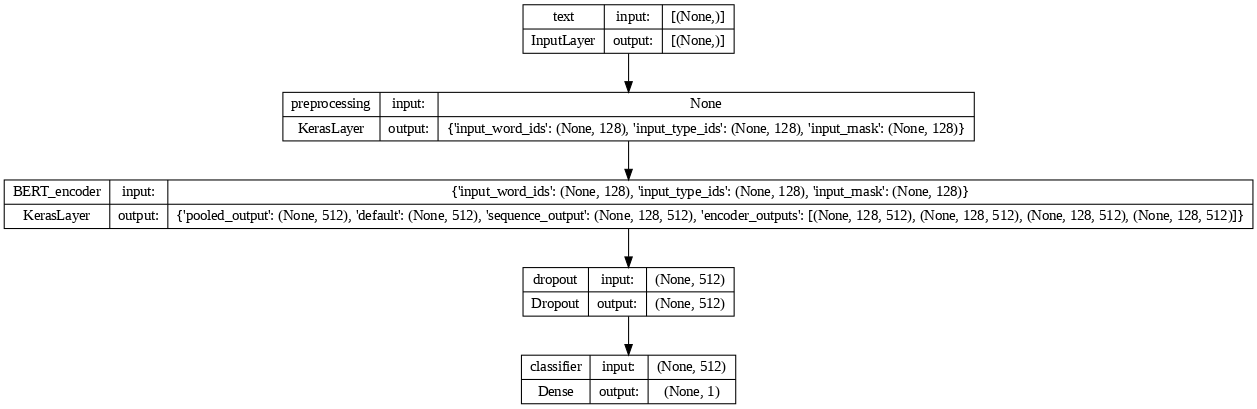

In [ ]:
tf.keras.utils.plot_model(model=classifier_model,show_shapes=True,dpi=76)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train,
                               y_train,
                               validation_data=(X_val, y_val),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/6
19/19 [==============================] - 200s 10s/step - loss: 0.7071 - binary_accuracy: 0.4950 - val_loss: 0.6757 - val_binary_accuracy: 0.5400
Epoch 2/6
19/19 [==============================] - 198s 10s/step - loss: 0.6981 - binary_accuracy: 0.5200 - val_loss: 0.6557 - val_binary_accuracy: 0.5600
Epoch 3/6
19/19 [==============================] - 195s 10s/step - loss: 0.6687 - binary_accuracy: 0.5450 - val_loss: 0.6311 - val_binary_accuracy: 0.6000
Epoch 4/6
19/19 [==============================] - 191s 10s/step - loss: 0.6539 - binary_accuracy: 0.5783 - val_loss: 0.6008 - val_binary_accuracy: 0.6550
Epoch 5/6
19/19 [==============================] - 201s 11s/step - loss: 0.6180 - binary_accuracy: 0.6133 - val_loss: 0.5630 - val_binary_accuracy: 0.7000
Epoch 6/6
19/19 [==============================] - 194s 10s/step - loss: 0.5447 - binary_accuracy: 0.6933 - val_loss: 0.5197 - val_bi

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


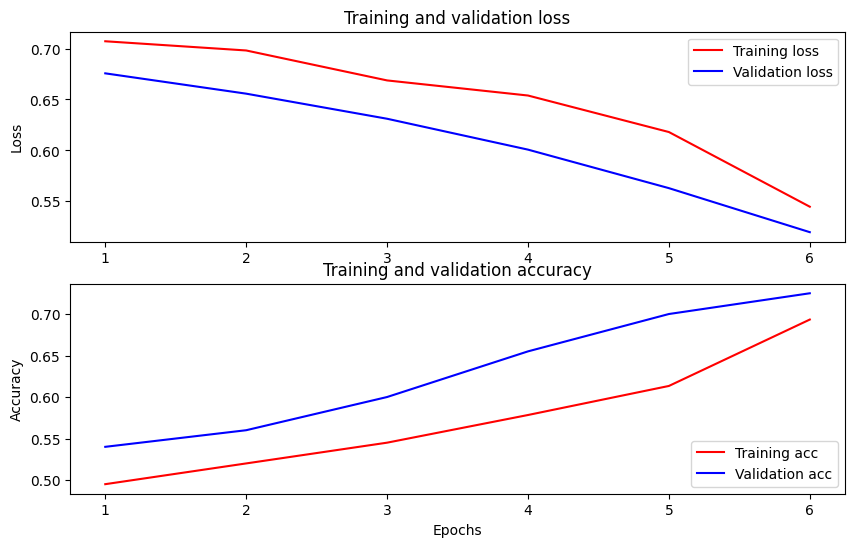

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

7/7 [==============================] - 16s 2s/step - loss: 0.5371 - binary_accuracy: 0.7300
Loss: 0.5371395945549011
Accuracy: 0.7300000190734863


In [ ]:
#performance metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#predicted values using the model
y_pred=classifier_model.predict(X_test)

print(y_pred.flatten())

7/7 [==============================] - 18s 2s/step
[-0.17018549 -0.06243111 -1.1007195  -0.75706255 -1.7224774  -0.53760535
  0.35123238 -0.13918738 -0.8996218   1.7929473   1.131921    0.4951342
 -0.35442546 -0.3049147  -1.9699008   0.1717956  -1.452898    2.196058
  0.28886476 -1.1363263   1.7296839  -0.35978106  0.02498191 -0.20727341
  0.9574987  -0.09162998 -1.0487924   1.8258766  -0.2983346   0.42552808
 -0.24320978 -0.184831   -0.06644671 -1.020373   -0.1873814  -0.3901303
 -0.6429644  -1.3261638   1.2291518  -1.242276   -0.593193   -0.3224701
 -0.6823499  -0.87440324 -0.718203   -0.30847254 -1.0093108  -0.9195964
  1.6920215   0.550194   -0.11707826  0.2456928  -1.1468481  -1.6630284
  0.3503594  -0.39140758  0.5601197   0.8312925  -0.38240623 -0.6560897
  0.34660384 -0.25862393 -0.4639623  -0.44524136 -0.95652205  0.29844353
  1.120553    1.5662231   1.4549295   1.1858642  -2.0553672   0.729942
 -1.0820858   0.6358497  -0.54316175  0.33812556 -0.32360816  1.4382565
 -0.3489553

In [ ]:
#len(y_pred)

for i in range(len(y_pred)):
  if y_pred[i]<0.5:
    y_pred[i] = 0
  else: y_pred[i] = 1

print(y_pred.flatten())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0.]


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

print(confusion_matrix(y_test, y_pred), '\n')
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n')

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

[[93  7]
 [47 53]] 

              precision    recall  f1-score   support

           0       0.66      0.93      0.78       100
           1       0.88      0.53      0.66       100

    accuracy                           0.73       200
   macro avg       0.77      0.73      0.72       200
weighted avg       0.77      0.73      0.72       200

Accuracy: 0.73
AUC: 0.7299999999999999


In [1]:
# Bert Base model

In [ ]:
import pandas as pd

reviews1 = pd.read_csv("preprocessed_data.csv")

In [ ]:
from sklearn.model_selection import train_test_split

#split and take the test set
X, X_test, y, y_test = (train_test_split(reviews1['Review'], reviews1['Sentiment'],
                                                     stratify=reviews1['Sentiment'],
                                                     test_size=0.2,
                                                     train_size=0.8
                                                     ))


In [ ]:

#split the train set (X) into train and validation
X_train, X_val, y_train, y_val = (train_test_split(X, y,
                                                     stratify=y,
                                                     test_size=0.25,
                                                     train_size=0.75
                                                     ))

In [ ]:
# BERT Base model
bert_model_name_base = 'bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle_base = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',
}

map_model_to_preprocess_base = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder_base = map_name_to_handle_base[bert_model_name_base]
tfhub_handle_preprocess_base = map_model_to_preprocess_base[bert_model_name_base]

print(f'BERT model selected           : {tfhub_handle_encoder_base}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess_base}')



BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess_base)

In [ ]:
reviews1['Review'][0]

'way plug unless converter'

In [ ]:
text_test = ["way plug unless converter"]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2126 13354  4983 10463  2121   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder_base)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder_base}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.8031844  -0.20758972 -0.5258936   0.67911196  0.275553   -0.1860798
  0.82500136  0.15810013 -0.12201077 -0.9999725  -0.10211996  0.33117846]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.4361078   0.00592588  0.11341256 ... -0.20318398  0.30340195
   0.64848965]
 [ 0.67738205 -0.22867835  0.48479223 ... -0.26405346  0.8888526
   0.21856847]
 [ 0.4647305  -0.04622331  0.40452498 ... -0.28890786  0.07800494
   0.17495659]
 ...
 [ 0.14765596 -0.22633085  0.5796255  ... -0.12018983 -0.14428772
   0.02443728]
 [-0.19250306 -0.5980969   0.22683778 ... -0.1859603  -0.06457866
   0.16677988]
 [ 0.10037521 -0.27360383  0.49363327 ... -0.17840512 -0.15814465
   0.13653997]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess_base, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder_base, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

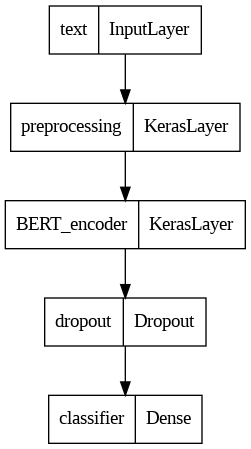

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
epochs = 6
steps_per_epoch = 600  #corresponding to the train set size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps) #10% of num_train_steps

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
#fine-tune BERT for classification
classifier_model.compile(optimizer,
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=[tf.keras.metrics.BinaryAccuracy()])
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

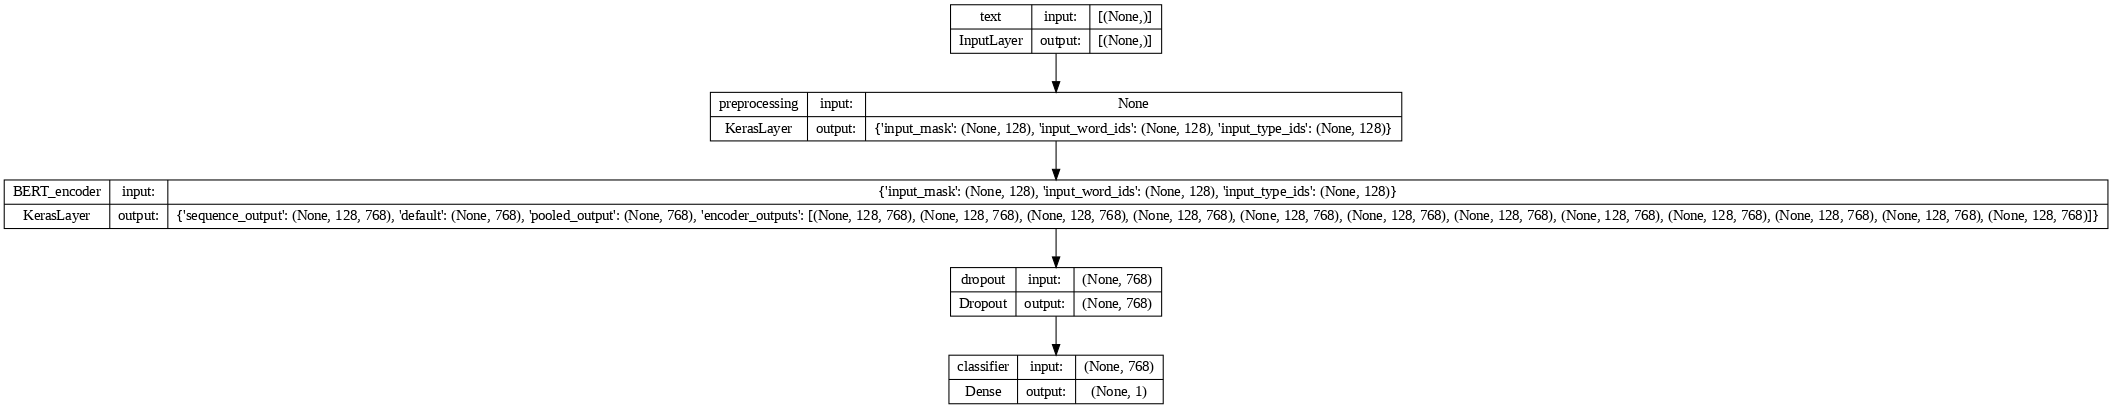

In [ ]:
tf.keras.utils.plot_model(model=classifier_model,show_shapes=True,dpi=76)

In [ ]:
print(f'Training model with {tfhub_handle_encoder_base}')
history = classifier_model.fit(X_train,
                               y_train,
                               validation_data=(X_val, y_val),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Epoch 1/6
19/19 [==============================] - 893s 45s/step - loss: 0.7323 - binary_accuracy: 0.5000 - val_loss: 0.7163 - val_binary_accuracy: 0.5000
Epoch 2/6
19/19 [==============================] - 831s 44s/step - loss: 0.7094 - binary_accuracy: 0.5017 - val_loss: 0.6805 - val_binary_accuracy: 0.5000
Epoch 3/6
19/19 [==============================] - 833s 44s/step - loss: 0.6816 - binary_accuracy: 0.5067 - val_loss: 0.6393 - val_binary_accuracy: 0.5050
Epoch 4/6
19/19 [==============================] - 832s 44s/step - loss: 0.6136 - binary_accuracy: 0.6117 - val_loss: 0.5571 - val_binary_accuracy: 0.7250
Epoch 5/6
19/19 [==============================] - 830s 44s/step - loss: 0.5100 - binary_accuracy: 0.7600 - val_loss: 0.4347 - val_binary_accuracy: 0.7800
Epoch 6/6
19/19 [==============================] - 830s 44s/step - loss: 0.4179 - binary_accuracy: 0.8033 - val_loss: 0.3944 - val_binary_accu

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


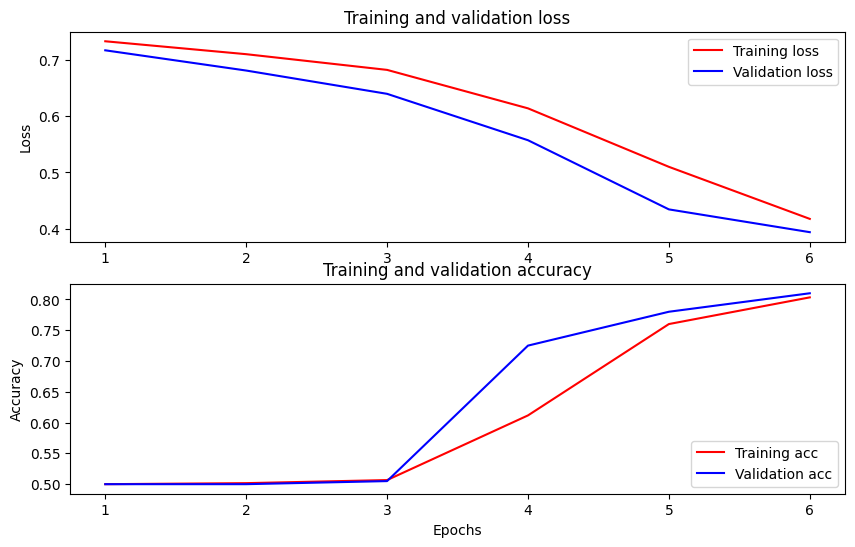

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

7/7 [==============================] - 78s 11s/step - loss: 0.3037 - binary_accuracy: 0.9000
Loss: 0.30370375514030457
Accuracy: 0.8999999761581421


In [ ]:
#performance metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#predicted values using the model
y_pred=classifier_model.predict(X_test)

print(y_pred.flatten())

7/7 [==============================] - 79s 11s/step
[ 2.4159863e+00 -2.3463151e+00  2.2567394e+00  2.3511596e+00
  1.7191044e+00 -1.9258856e+00 -9.3712109e-01 -1.4614269e+00
 -1.8692244e+00 -7.0203948e-01 -1.0730515e+00  2.3802643e+00
  2.3081167e+00  2.4291453e+00  6.3800764e-01 -2.3700879e+00
  1.9543356e+00 -1.0304081e+00 -1.7343026e+00  2.2279806e+00
 -1.8928668e+00 -2.4967873e+00 -2.3931785e+00  2.4588828e+00
 -2.3931785e+00  2.6628652e+00 -1.9019076e+00 -2.4479711e+00
 -6.7579442e-01  2.5889075e+00  5.4501903e-01  9.3088329e-01
  2.2062366e+00 -2.3443356e+00  2.4568620e+00  2.2215772e+00
  1.8720988e+00 -1.5947286e+00 -6.2790680e-01 -2.4350090e+00
  2.6572313e+00  7.6151526e-01  2.4806755e+00 -1.4657909e+00
 -1.7976930e+00 -2.2874856e+00 -2.1355715e+00  2.5790143e+00
 -2.3953424e+00 -1.9184054e+00  2.4879367e+00 -1.1312562e+00
  2.5006580e+00  2.3489757e+00 -2.3230479e+00 -1.7712116e+00
  2.6522779e+00 -1.4514889e+00  2.5573561e+00  2.6966760e+00
  2.5744452e+00 -2.0262048e+00  1

In [ ]:
#len(y_pred)

for i in range(len(y_pred)):
  if y_pred[i]<0.5:
    y_pred[i] = 0
  else: y_pred[i] = 1

print(y_pred.flatten())

[1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 0. 1.]


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

print(confusion_matrix(y_test, y_pred), '\n')
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)), '\n')

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

[[91  9]
 [11 89]] 

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       100
           1       0.91      0.89      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200

Accuracy: 0.9
AUC: 0.9000000000000001
